In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import MultiPoint


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import imblearn.under_sampling
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [3]:
# def CreateSQLTable(sqltablename, df):
#     SqlDtype = ''
#     ret_str = 'CREATE TABLE ' + sqltablename + ' (\n'
#     for col in df:
#         if df[col].dtype == 'int64':
#             SqlDtype = 'INT'
#         if df[col].dtype == 'float64':
#             SqlDtype = 'DOUBLE PRECISION'
#         if df[col].dtype == 'object':
#             SqlDtype = 'TEXT'
#         ret_str = ret_str + col + '\t' + SqlDtype + ',' + '\n'
#     ret_str = ret_str[:-2] + ');'
#     return print(ret_str)

In [4]:
cnx = create_engine('postgresql://postgres@localhost:5432/postgres')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
df=pd.read_sql_query('''SELECT * FROM manhattan''',cnx)


From data source; This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations (which we were using more in June and July 2013), and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).

In [4]:
df.head()

,tripduration,startstationid,startstationlat,startstationlong,endstationid,endstationlat,endstationlong,usertype,id,startid,ssid,startstationboro,startstationhood,endid,esid,endstationboro,endstationhood,hoursid,hour
0,1023,2006,40.765909,-73.976342,3282,40.783070,-73.959390,Customer,4796,4796,2006,manhattan,midtown,4796,3282,manhattan,uptown,4796,12.0
1,1627,368,40.730386,-74.002150,2006,40.765909,-73.976342,Subscriber,5757,5757,368,manhattan,village,5757,2006,manhattan,midtown,5757,13.0
2,3788,3160,40.778968,-73.973747,3165,40.775794,-73.976206,Customer,6930,6930,3160,manhattan,uptown,6930,3165,manhattan,uptown,6930,14.0
3,772,340,40.712690,-73.987763,259,40.701221,-74.012342,Subscriber,7291,7291,340,manhattan,village,7291,259,manhattan,fidi,7291,14.0
4,2047,3163,40.773407,-73.977825,3323,40.798186,-73.960591,Customer,7867,7867,3163,manhattan,uptown,7867,3323,manhattan,uptown,7867,14.0


In [7]:
df.set_index(df['id'], inplace=True)

In [8]:
df.drop(columns=['id','startid', 'ssid', 'endid', 'esid','hoursid'], inplace=True)

In [9]:
df.describe()

,tripduration,startstationid,startstationlat,startstationlong,endstationid,endstationlat,endstationlong,hour
count,1.150116e+07,1.150116e+07,1.150116e+07,1.150116e+07,1.150116e+07,1.150116e+07,1.150116e+07,1.150116e+07
mean,8.676842e+02,1.183972e+03,4.074582e+01,-7.398723e+01,1.172239e+03,4.074548e+01,-7.398739e+01,1.386553e+01
std,5.772294e+03,1.266084e+03,2.275281e-02,1.514019e-02,1.260892e+03,2.266614e-02,1.519664e-02,4.787711e+00
min,6.100000e+01,7.200000e+01,4.070122e+01,-7.401713e+01,7.200000e+01,4.070122e+01,-7.401713e+01,0.000000e+00
25%,3.830000e+02,3.580000e+02,4.072904e+01,-7.399725e+01,3.580000e+02,4.072885e+01,-7.399726e+01,1.000000e+01
50%,6.230000e+02,4.790000e+02,4.074475e+01,-7.398856e+01,4.780000e+02,4.074445e+01,-7.398860e+01,1.500000e+01
75%,1.043000e+03,3.132000e+03,4.076088e+01,-7.397791e+01,3.002000e+03,4.076088e+01,-7.397806e+01,1.800000e+01
max,6.350358e+06,3.649000e+03,4.081439e+01,-7.393118e+01,3.649000e+03,4.081439e+01,-7.393118e+01,2.300000e+01


### Start here if working from pickled or csvdata

In [2]:
#### PICKLE OR CSV #####

# with open('manhattan.pkl', 'wb') as picklefile:
#     pickle.dump(df, picklefile)

# with open("manhattan.pkl", 'rb') as picklefile: 
#      df = pickle.load(picklefile)

# pickles: manhattan.pkl - this is 11M rows
# csvs: manhattan100kgeo.csv more rough, in order to include distance and speed
#      manhattanonly100k.csv very clean, just geographic data

#mdf.sample(n=100000, random_state=42).to_csv('manhattan100kgeo.csv')
#df=pd.read_csv("manhattan100kgeo.csv")

In [8]:
df.head()

,tripduration,startstationid,startstationlat,startstationlong,endstationid,endstationlat,endstationlong,usertype,startstationboro,startstationhood,endstationboro,endstationhood,hour
id,,,,,,,,,,,,,
4796,1023,2006,40.765909,-73.976342,3282,40.783070,-73.959390,Customer,manhattan,midtown,manhattan,uptown,12.0
5757,1627,368,40.730386,-74.002150,2006,40.765909,-73.976342,Subscriber,manhattan,village,manhattan,midtown,13.0
6930,3788,3160,40.778968,-73.973747,3165,40.775794,-73.976206,Customer,manhattan,uptown,manhattan,uptown,14.0
7291,772,340,40.712690,-73.987763,259,40.701221,-74.012342,Subscriber,manhattan,village,manhattan,fidi,14.0
7867,2047,3163,40.773407,-73.977825,3323,40.798186,-73.960591,Customer,manhattan,uptown,manhattan,uptown,14.0


In [10]:
# RUN THESE IF IMPORTING FROM SQL
#drop rows with no usertype information
df.dropna(axis='index', subset=['usertype'], inplace=True)

#strip spaces in 'usertype'
df['usertype']=[x.strip() for x in df['usertype']]

#turn target categories into numbers: subscriber=0, customer=1
usermap={'Subscriber':0,'Customer':1}
df['target']=df.loc[:,'usertype'].map(usermap)

#drop columns if working from manhattanonly100k.csv
df=df.drop(columns=['startstationboro', 'endstationboro'])

In [11]:
#create smaller sample if working from SQL, save to csv
#df.sample(n=100000, random_state=42).to_csv("XXXX.csv")

In [12]:
def get_start_point(row):
    p=Point(df.loc[row,'startstationlong'], df.loc[row, 'startstationlat'])
    return p

def get_end_point(row):
    p=Point(df.loc[row,'endstationlong'], df.loc[row, 'endstationlat'])
    return p

def get_distance(row):
    return df.loc[row,'startpoint'].distance(df.loc[row,'endpoint'])

def get_speed(row):
    return df.loc[row,'distance']/(df.loc[row,'tripduration']/60) 

In [13]:
df['startpoint']=[get_start_point(row) for row in df.index]

In [14]:
df['endpoint']=[get_end_point(row) for row in df.index]

In [15]:
df['distance']=[get_distance(row) for row in df.index]

In [16]:
df['speed']=[get_speed(row) for row in df.index]

In [17]:
df.head()

,tripduration,startstationid,startstationlat,startstationlong,endstationid,endstationlat,endstationlong,usertype,startstationhood,endstationhood,hour,target,startpoint,endpoint,distance,speed
id,,,,,,,,,,,,,,,,
4796,1023,2006,40.765909,-73.976342,3282,40.783070,-73.959390,Customer,midtown,uptown,12.0,1,POINT (-73.97634151 40.76590936),POINT (-73.95939 40.78307),0.024121,0.001415
5757,1627,368,40.730386,-74.002150,2006,40.765909,-73.976342,Subscriber,village,midtown,13.0,0,POINT (-74.00214988 40.73038599),POINT (-73.97634151 40.76590936),0.043909,0.001619
6930,3788,3160,40.778968,-73.973747,3165,40.775794,-73.976206,Customer,uptown,uptown,14.0,1,POINT (-73.97374737 40.77896784),POINT (-73.9762057363987 40.7757937668367),0.004015,0.000064
7291,772,340,40.712690,-73.987763,259,40.701221,-74.012342,Subscriber,village,fidi,14.0,0,POINT (-73.98776323 40.71269042),POINT (-74.01234218 40.70122128),0.027123,0.002108
7867,2047,3163,40.773407,-73.977825,3323,40.798186,-73.960591,Customer,uptown,uptown,14.0,1,POINT (-73.97782542 40.7734066),POINT (-73.9605909006 40.7981856),0.030183,0.000885


Text(0.5,1,'Customers VS Subscribers Avg Duration of Trip')

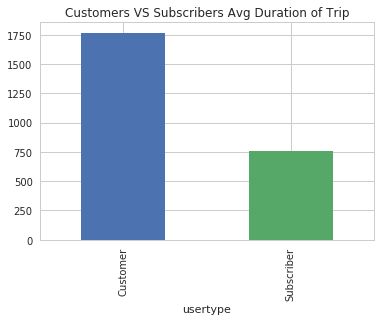

In [18]:
df.groupby("usertype").tripduration.mean().plot(kind='bar')
plt.title("Customers VS Subscribers Avg Duration of Trip")

Text(0.5,1,'Customers VS Subscribers Avg Speed of Trip')

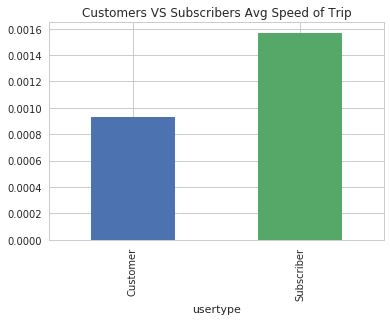

In [19]:
df.groupby("usertype").speed.mean().plot(kind='bar')
plt.title("Customers VS Subscribers Avg Speed of Trip")

Text(0.5,1,'Customers VS Subscribers Avg Distance of Trip')

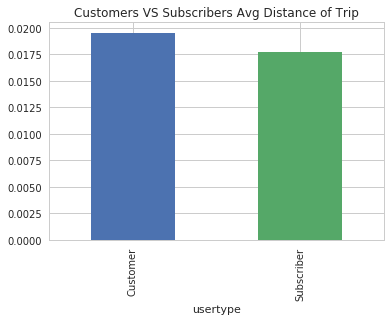

In [20]:
df.groupby("usertype").distance.mean().plot(kind='bar')
plt.title("Customers VS Subscribers Avg Distance of Trip")

In [23]:
df.head()

,tripduration,startstationid,startstationlat,startstationlong,endstationid,endstationlat,endstationlong,usertype,startstationhood,endstationhood,hour,target,startpoint,endpoint,distance,speed
id,,,,,,,,,,,,,,,,
4796,1023,2006,40.765909,-73.976342,3282,40.783070,-73.959390,Customer,midtown,uptown,12.0,1,POINT (-73.97634151 40.76590936),POINT (-73.95939 40.78307),0.024121,0.001415
5757,1627,368,40.730386,-74.002150,2006,40.765909,-73.976342,Subscriber,village,midtown,13.0,0,POINT (-74.00214988 40.73038599),POINT (-73.97634151 40.76590936),0.043909,0.001619
6930,3788,3160,40.778968,-73.973747,3165,40.775794,-73.976206,Customer,uptown,uptown,14.0,1,POINT (-73.97374737 40.77896784),POINT (-73.9762057363987 40.7757937668367),0.004015,0.000064
7291,772,340,40.712690,-73.987763,259,40.701221,-74.012342,Subscriber,village,fidi,14.0,0,POINT (-73.98776323 40.71269042),POINT (-74.01234218 40.70122128),0.027123,0.002108
7867,2047,3163,40.773407,-73.977825,3323,40.798186,-73.960591,Customer,uptown,uptown,14.0,1,POINT (-73.97782542 40.7734066),POINT (-73.9605909006 40.7981856),0.030183,0.000885


In [22]:
#df=df.set_index(df['id']).drop(columns=['id'])

In [24]:
df=df.drop(columns=['startstationlat', 'startstationlong','endstationlat','endstationlong','startpoint','endpoint', 'usertype'])

In [25]:
df=pd.get_dummies(df)

In [26]:
df.columns

Index(['tripduration', 'startstationid', 'endstationid', 'hour', 'target',
       'distance', 'speed', 'startstationhood_fidi', 'startstationhood_harlem',
       'startstationhood_midtown', 'startstationhood_uptown',
       'startstationhood_village', 'endstationhood_fidi',
       'endstationhood_harlem', 'endstationhood_midtown',
       'endstationhood_uptown', 'endstationhood_village'],
      dtype='object')

In [27]:
X=df.drop(columns=["target"])
y=df['target']
RUS = imblearn.under_sampling.RandomUnderSampler(ratio='auto', random_state=42)

In [28]:
#Split data into 3: 56% train ??% validation, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018) #30% test

X_train, y_train = RUS.fit_sample(X_train, y_train) #undersample

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2019) #80% of 70% train, 20% of 70% val

In [29]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
print(datetime.now())

2018-08-12 17:31:12.363440


In [30]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #classification objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [31]:
print(datetime.now())

2018-08-12 18:02:19.431204


In [32]:
mean_squared_error(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.1716951502217518

In [33]:
f1_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.828127879122904

In [34]:
print(metrics.precision_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit), average=None))

[0.82636831 0.83025534]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
print(confusion_matrix(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[144174  29403]
 [ 30293 143816]]


In [36]:
print(classification_report(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

             precision    recall  f1-score   support

          0       0.83      0.83      0.83    173577
          1       0.83      0.83      0.83    174109

avg / total       0.83      0.83      0.83    347686



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


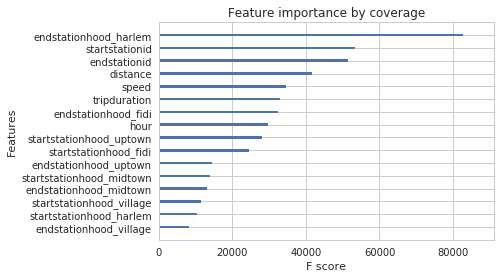

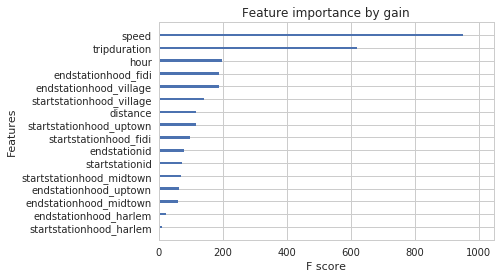

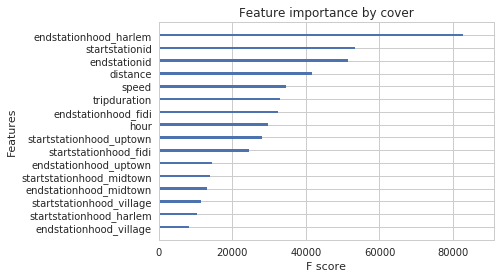

In [37]:
xgb.plot_importance(gbm, importance_type="cover", title="Feature importance by coverage", show_values=False)
xgb.plot_importance(gbm, importance_type='gain',  title='Feature importance by gain', show_values=False)
xgb.plot_importance(gbm, importance_type='cover',  title='Feature importance by cover', show_values=False)